# Case Study 3 - Email Spam

__Team Members:__ Amber Clark, Andrew Leppla, Jorge Olmos, Paritosh Rai

# Team Strategy

Emails are read in.  Kept: From, Subject, Body.
- Remove \n with regex
- Remove other non-alphabetic characters - keep the counts?

Feature Extraction:
1. Vectorization - TFIDF (removes stop words)
If we have time:
2. Created 'trusted' and 'spam' email address book to filter spam - IS THIS OUT OF SCOPE PER SCOPE?

Model:
Classification with Naive Bayes - Amber, Jorge
1. Subject Only = Baseline
2. Body (+Subject?)

Clustering:
DBSCAN with cosine distance for NLP - Andrew, Paritosh

# Content
* [Business Understanding](#business-understanding)
    - [Scope](#scope)
    - [Introduction](#introduction)
    - [Methods](#methods)
    - [Results](#results)
* [Data Evaluation](#data-evaluation)
    - [Loading Data](#loading-data) 
    - [Data Summary](#data-summary)
    - [Missing Values](#missing-values)
    - [Feature Removal](#feature-removal)
    - [Exploratory Data Analysis (EDA)](#eda)
    - [Assumptions](#assumptions)
* [Model Preparations](#model-preparations)
    - [Sampling & Scaling Data](#sampling-scaling-data)
    - [Proposed Method](#proposed-metrics)
    - [Evaluation Metrics](#evaluation-metrics)
    - [Feature Selection](#feature-selection)
* [Model Building & Evaluations](#model-building)
    - [Sampling Methodology](#sampling-methodology)
    - [Model](#model)
    - [Performance Analysis](#performance-analysis)
* [Model Interpretability & Explainability](#model-explanation)
    - [Examining Feature Importance](#examining-feature-importance)
* [Conclusion](#conclusion)
    - [Final Model Proposal](#final-model-proposal)
    - [Future Considerations and Model Enhancements](#model-enhancements)
    - [Alternative Modeling Approaches](#alternative-modeling-approaches)

# Business Understanding & Executive Summary <a id='business-understanding'/>

What are we trying to solve for and why is it important?


### Scope <a id='scope'/>


### Introduction <a id='introduction'/>


### Methods <a id='methods'/>
 
 
### Results <a id='results'/>
 

# Data Evaluation <a id='data-evaluation'>
    

Summarize data being used?

Are there missing values?

Which variables are needed and which are not?

What assumptions or conclusions are you drawing about your data?

In [183]:
# standard libraries
import pandas as pd
import numpy as np
import re
import os
from IPython.display import Image
import sklearn
import time
# email
from email import policy
from email.parser import BytesParser

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from tabulate import tabulate

# data pre-processing
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer

# clustering
from sklearn.cluster import DBSCAN
from statistics import stdev

# prediction models
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.ensemble import VotingClassifier
from sklearn.model_selection import cross_val_score

# import warnings filter
'''import warnings
warnings.filterwarnings('ignore')
from warnings import simplefilter 
simplefilter(action='ignore', category=FutureWarning)'''

"import warnings\nwarnings.filterwarnings('ignore')\nfrom warnings import simplefilter \nsimplefilter(action='ignore', category=FutureWarning)"

In [211]:
from nltk.corpus import words
import nltk
nltk.download('words')



[nltk_data] Downloading package words to
[nltk_data]     /Users/jorgeolmos/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [236]:
english_words = words.words()

In [237]:
english_words

['A',
 'a',
 'aa',
 'aal',
 'aalii',
 'aam',
 'Aani',
 'aardvark',
 'aardwolf',
 'Aaron',
 'Aaronic',
 'Aaronical',
 'Aaronite',
 'Aaronitic',
 'Aaru',
 'Ab',
 'aba',
 'Ababdeh',
 'Ababua',
 'abac',
 'abaca',
 'abacate',
 'abacay',
 'abacinate',
 'abacination',
 'abaciscus',
 'abacist',
 'aback',
 'abactinal',
 'abactinally',
 'abaction',
 'abactor',
 'abaculus',
 'abacus',
 'Abadite',
 'abaff',
 'abaft',
 'abaisance',
 'abaiser',
 'abaissed',
 'abalienate',
 'abalienation',
 'abalone',
 'Abama',
 'abampere',
 'abandon',
 'abandonable',
 'abandoned',
 'abandonedly',
 'abandonee',
 'abandoner',
 'abandonment',
 'Abanic',
 'Abantes',
 'abaptiston',
 'Abarambo',
 'Abaris',
 'abarthrosis',
 'abarticular',
 'abarticulation',
 'abas',
 'abase',
 'abased',
 'abasedly',
 'abasedness',
 'abasement',
 'abaser',
 'Abasgi',
 'abash',
 'abashed',
 'abashedly',
 'abashedness',
 'abashless',
 'abashlessly',
 'abashment',
 'abasia',
 'abasic',
 'abask',
 'Abassin',
 'abastardize',
 'abatable',
 'abate

## Loading Data <a id='loading-data'>

In [2]:
%%javascript 
IPython.notebook.kernel.execute('nb_name = "' + IPython.notebook.notebook_name + '"')

<IPython.core.display.Javascript object>

In [3]:
nb_name

'case_study3_template.ipynb'

In [4]:
import os
notebook_path = os.path.abspath(nb_name)

In [5]:
notebook_path

'/Users/jorgeolmos/Documents/qtw1/Case Study 1/ds7333_case_study_3/case_study3_template.ipynb'

In [6]:
file_spam = os.path.join(os.path.dirname(notebook_path), "SpamAssassinMessages")

In [7]:
file_spam

'/Users/jorgeolmos/Documents/qtw1/Case Study 1/ds7333_case_study_3/SpamAssassinMessages'

In [8]:
def get_all_files(folder):
    file_list = []
    if os.path.exists(folder):
        for root, dirs, files in os.walk(folder):
            for file in files:
                file_list.append(os.path.join(root,file))
    return file_list

In [9]:
folders = os.listdir(file_spam)
folders

['spam', 'hard_ham', 'spam_2', 'easy_ham', 'easy_ham_2']

In [10]:
# Get the file names in each folder (list of lists)
files = [ os.listdir(file_spam+ '/'+ folder) for folder in folders] 

# Create a list of dataframes for all of the folders
emails = [ pd.DataFrame({'folder' : [], 'from' : [], 'subject' : [], 'body': []}) ]*len(folders)

# Add folder path to file names
for i in range(0,len(folders)):
    for j in range(0, len(files[i])):
        files[i][j] = str(file_spam +'/' + folders[i] + '/' + files[i][j]) 
        
        # Parse and extract email 'subject' and 'from'
        with open(files[i][j], 'rb') as fp:
            msg = BytesParser(policy=policy.default).parse(fp)
            
            # Error checking when reading in body for some html-based emails from spam folders
            try:
                simplest = msg.get_body(preferencelist=('plain', 'html'))
                try:
                    new_row = {'folder': folders[i], 'from': msg['from'], 'subject': msg['subject'], 'body': simplest.get_content()}
                    emails[i] = emails[i].append(new_row, ignore_index=True)
                except:
                    new_row = {'folder': folders[i], 'from': msg['from'], 'subject':msg['subject'], 'body':'Error(html)'}
                    emails[i] = emails[i].append(new_row, ignore_index=True)
            except:
                new_row = {'folder': folders[i], 'from': msg['from'], 'subject':msg['subject'], 'body':'Error(html)'}
                emails[i] = emails[i].append(new_row, ignore_index=True)

In [11]:
# Emails per folder
print("# files in folders:", [len(i) for i in files])
print("# emails read in  :", [i.shape[0] for i in emails])

# Total emails
print( "\n# total emails =", sum([len(i) for i in files]) )

# files in folders: [1001, 501, 1398, 5052, 1401]
# emails read in  : [1001, 501, 1398, 5052, 1401]

# total emails = 9353


In [12]:
# Create single dataframe from all folders
df = pd.concat( [emails[i] for i in range(0, len(emails))], axis=0)

#  Keep the indices from the folders
df = df.reset_index() 

# create response column from folder names
spam = [(i=='spam' or i=='spam_2') for i in df['folder']]
df = pd.concat([df, pd.Series(spam).astype(int)], axis=1)

df.columns = ['folder_idx', 'folder', 'from', 'subject', 'body','spam']

df.shape

(9353, 6)

In [33]:
print(sklearn.__version__)

0.23.2


In [13]:
df.head()

,folder_idx,folder,from,subject,body,spam
0,0,spam,pamela4701@eudoramail.com,Let us find the right mortgage lender for you ...,"Dear Homeowner,\n \nInterest Rates are at thei...",1
1,1,spam,CopyYourDVD <atomica2020@hotmail.com>,"Friend, Copy ANY DVD or Playstation Game with ...","Friend,Now you can copy DVD's and Games\nhttp:...",1
2,2,spam,IQ - Safe Harbor <sh@insiq.us>,5% Guaranteed for Eight Years,Pocket the newest 8 year annuity!\t Pocket th...,1
3,3,spam,Customer Service <greatoffers@sendgreatoffers....,Congratulations! You Get a Free Handheld Organ...,<html><head>\n<title>Congratulations! You Get ...,1
4,4,spam,don <apf@wu-wien.ac.at>,PROTECT YOUR INFORMATION AND YOUR COMPUTER,ATTENTION: This is a MUST for ALL Computer Use...,1


In [14]:
CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')
def cleanhtml(raw_html):
    cleantext = re.sub(CLEANR, '', raw_html)
    return cleantext

In [15]:
def cleanAndSplit(raw_text): 
    temp = []
    for word in raw_text.split():
        temp.append(re.sub(r"[^a-zA-Z0-9]","",word).lower())
    return temp

In [16]:
def cleanBody(raw_content):
    if(pd.isna(raw_content)):
        return []
    clean_from_html = cleanhtml(raw_content)
    out = cleanAndSplit(clean_from_html)
    return out

In [17]:
def combine(content):
    joined = np.concatenate((*content[['clean_body']], *content[['clean_subject']]))
    return joined

In [18]:
df['clean_body'] = df['body'].apply(cleanBody)

In [19]:
df['clean_subject'] = df['subject'].apply(cleanBody)

In [20]:
df['joined'] = df[['clean_body','clean_subject']].agg(combine, axis=1)

In [21]:
df.head()

,folder_idx,folder,from,subject,body,spam,clean_body,clean_subject,joined
0,0,spam,pamela4701@eudoramail.com,Let us find the right mortgage lender for you ...,"Dear Homeowner,\n \nInterest Rates are at thei...",1,"[dear, homeowner, interest, rates, are, at, th...","[let, us, find, the, right, mortgage, lender, ...","[dear, homeowner, interest, rates, are, at, th..."
1,1,spam,CopyYourDVD <atomica2020@hotmail.com>,"Friend, Copy ANY DVD or Playstation Game with ...","Friend,Now you can copy DVD's and Games\nhttp:...",1,"[friendnow, you, can, copy, dvds, and, games, ...","[friend, copy, any, dvd, or, playstation, game...","[friendnow, you, can, copy, dvds, and, games, ..."
2,2,spam,IQ - Safe Harbor <sh@insiq.us>,5% Guaranteed for Eight Years,Pocket the newest 8 year annuity!\t Pocket th...,1,"[pocket, the, newest, 8, year, annuity, pocket...","[5, guaranteed, for, eight, years]","[pocket, the, newest, 8, year, annuity, pocket..."
3,3,spam,Customer Service <greatoffers@sendgreatoffers....,Congratulations! You Get a Free Handheld Organ...,<html><head>\n<title>Congratulations! You Get ...,1,"[congratulations, you, get, a, free, handheld,...","[congratulations, you, get, a, free, handheld,...","[congratulations, you, get, a, free, handheld,..."
4,4,spam,don <apf@wu-wien.ac.at>,PROTECT YOUR INFORMATION AND YOUR COMPUTER,ATTENTION: This is a MUST for ALL Computer Use...,1,"[attention, this, is, a, must, for, all, compu...","[protect, your, information, and, your, computer]","[attention, this, is, a, must, for, all, compu..."


## Data Summary <a id='data-summary'>

## Missing Values <a id='missing-values'>



In [22]:
# Rows where body couldn't be read in = 'Error(html)'
df.loc[df['body']=='Error(html)']

# All spam emails

,folder_idx,folder,from,subject,body,spam,clean_body,clean_subject,joined
460,460,spam,Affordable Computer Supply <InkjetDeals@acsmsu...,Printer Cartridges as low as $1.21 each!,Error(html),1,[errorhtml],"[printer, cartridges, as, low, as, 121, each]","[errorhtml, printer, cartridges, as, low, as, ..."
522,522,spam,zzzz@netscape.net,Collect Your Money! Time:1:30:33 AM,Error(html),1,[errorhtml],"[collect, your, money, time13033, am]","[errorhtml, collect, your, money, time13033, am]"
549,549,spam,eb@via.ecp.fr,"Over $100,000 Per Year Possible On The Net! N...",Error(html),1,[errorhtml],"[over, 100000, per, year, possible, on, the, n...","[errorhtml, over, 100000, per, year, possible,..."
793,793,spam,Affordable Computer Supply <InkjetDeals@acsmsu...,Printer Cartridges as low as $1.21 each!,Error(html),1,[errorhtml],"[printer, cartridges, as, low, as, 121, each]","[errorhtml, printer, cartridges, as, low, as, ..."
874,874,spam,"""Books@Books""@BlackRealityPublishing.com","Free Excerpt; Baby Makers, Loser Choosers, & ...",Error(html),1,[errorhtml],"[free, excerpt, baby, makers, loser, choosers,...","[errorhtml, free, excerpt, baby, makers, loser..."
905,905,spam,eb@via.ecp.fr,"Over $100,000 Per Year Possible On The Net! N...",Error(html),1,[errorhtml],"[over, 100000, per, year, possible, on, the, n...","[errorhtml, over, 100000, per, year, possible,..."
918,918,spam,"""Books@Books""@BlackRealityPublishing.com","Free Excerpt; Baby Makers, Loser Choosers, & ...",Error(html),1,[errorhtml],"[free, excerpt, baby, makers, loser, choosers,...","[errorhtml, free, excerpt, baby, makers, loser..."
949,949,spam,zzzz@netscape.net,Collect Your Money! Time:1:30:33 AM,Error(html),1,[errorhtml],"[collect, your, money, time13033, am]","[errorhtml, collect, your, money, time13033, am]"
1523,21,spam_2,targetemailextractor@btamail.net.cn,"Direct Email Blaster, Email extractor, email d...",Error(html),1,[errorhtml],"[direct, email, blaster, email, extractor, ema...","[errorhtml, direct, email, blaster, email, ext..."
1524,22,spam_2,iqsoftware@export2000.ro,[Avfs] Romanian Software Production & Export,Error(html),1,[errorhtml],"[avfs, romanian, software, production, , export]","[errorhtml, avfs, romanian, software, producti..."


In [23]:
# Count of body read Errors
df.loc[df['body']=='Error(html)'].shape[0]

33

In [24]:
# Look at file example with Error(html)
with open(files[4][1], 'rb') as fp:
    msg = BytesParser(policy=policy.default).parse(fp)
print(msg)

Return-Path: <webmake-talk-admin@example.sourceforge.net>
Delivered-To: yyyy@localhost.netnoteinc.com
Received: from localhost (localhost [127.0.0.1])
	by phobos.labs.netnoteinc.com (Postfix) with ESMTP id E877243C36
	for <jm@localhost>; Tue, 20 Aug 2002 06:51:13 -0400 (EDT)
Received: from phobos [127.0.0.1]
	by localhost with IMAP (fetchmail-5.9.0)
	for jm@localhost (single-drop); Tue, 20 Aug 2002 11:51:13 +0100 (IST)
Received: from usw-sf-list2.sourceforge.net (usw-sf-fw2.sourceforge.net
    [216.136.171.252]) by dogma.slashnull.org (8.11.6/8.11.6) with ESMTP id
    g7K6a5Z27627 for <jm@jmason.org>; Tue, 20 Aug 2002 07:36:05 +0100
Received: from usw-sf-list1-b.sourceforge.net ([10.3.1.13]
    helo=usw-sf-list1.sourceforge.net) by usw-sf-list2.sourceforge.net with
    esmtp (Exim 3.31-VA-mm2 #1 (Debian)) id 17h2cW-00059K-00; Mon,
    19 Aug 2002 23:36:04 -0700
Received: from docserver.cac.washington.edu ([140.142.32.13]) by
    usw-sf-list1.sourceforge.net with esmtp (Cipher TLSv1:DES

In [25]:
df.isna().sum()

folder_idx        0
folder            0
from              5
subject          12
body              0
spam              0
clean_body        0
clean_subject     0
joined            0
dtype: int64

In [26]:
# Replace NaN and None values with 'No Subject'
df.loc[ df['subject'].isna(), 'subject'] = 'No Subject'
df.loc[ df['subject']=='', 'subject'] = 'No Subject'

## Feature Removal <a id='feature-removal'>

## Exploratory Data Analysis (EDA) <a id='eda'>

In [27]:
df['spam'].value_counts()

0    6954
1    2399
Name: spam, dtype: int64

### Clustering
- Use DBSCAN with cosine distance for NLP.  
- Try to get approx. 5 clusters to dissect and explain
- Look for descriptors for the clusters, like business vs. personal emails, IT emails, etc.

In [28]:
def dummy_fun(doc):
    return doc
vectorizer = TfidfVectorizer(analyzer='word', tokenizer=dummy_fun, preprocessor=dummy_fun, token_pattern=None, stop_words='english')

In [29]:
features_subject = vectorizer.fit_transform(df['clean_subject'])

/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:383: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['b', 'c', 'd', 'e', 'f', 'g', 'h', 'k', 'l', 'm', 'n', 'o', 'p', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [30]:
dbscan = DBSCAN(metric='cosine', min_samples=125)
eps_clusters = []

for j in range(75,126,25):
    dbscan.min_samples = j
    for i in range(60,76,5):
        dbscan.eps = i/100
        clustering = pd.Series( dbscan.fit_predict(features_subject) )
        
        cluster_counts = list( clustering.value_counts().sort_index() )
        cluster_counts.pop(0) # remove -1 cluster which is a non-cluster 
        num_clusters = len(cluster_counts)
        
        clustering_spam = pd.concat([clustering, df['spam']], axis=1)
        clustering_spam.columns = ['cluster', 'spam']       
        clustering_spam_counts = pd.DataFrame( clustering_spam.value_counts() ).reset_index()
        cluster_purity = list( ( clustering_spam_counts[['cluster']].value_counts()==1 ).sort_index() )
        cluster_purity.pop(0) # remove -1 cluster which is a non-cluster
        num_pure_clusters = sum(cluster_purity)
        num_pure_emails = sum( np.multiply(cluster_counts, cluster_purity) )
        
        eps_clusters.append([ dbscan.min_samples, dbscan.eps, num_clusters, num_pure_clusters, num_pure_emails])

clusters_df = pd.DataFrame(eps_clusters, columns = ['min_samples','epsilon', '# clusters', '# pure clusters', '# pure emails'])
clusters_df.sort_values(by='# pure emails', ascending=False)

,min_samples,epsilon,# clusters,# pure clusters,# pure emails
10,125,0.70,6,4,635
2,75,0.70,8,5,569
7,100,0.75,6,3,540
11,125,0.75,6,3,540
6,100,0.70,6,3,429
0,75,0.60,4,3,327
5,100,0.65,4,2,303
9,125,0.65,4,2,303
3,75,0.75,5,2,300
4,100,0.60,3,2,242


## Final Clusters - Insights

min_samples=100, epsilon=0.65 had 4 pure clusters that contained only 'ham' emails.  These clusters could be used to filter or pre-process emails before Naive Bayes classification.  

- Cluster 0 : News & Dates
- Cluster 1 : Pain (ouch, hurts)
- Cluster 2 : Spambayes 
- Cluster 3 : razorusers
- Cluster 4 : [Spambayes] & package

min_samples could be decreased to 50 or less which would give more pure emails but many more clusters to explore and manage.  

In [297]:
# Most clusters with the lowest spread (stdev) in cluster counts
dbscan.min_samples = 125
dbscan.eps = 0.7

clusters = dbscan.fit_predict(features_subject)
clusters = pd.Series(clusters)
clusters.index = df.index
subject_clusters = pd.concat([ clusters, df['clean_subject'], df['spam'] ], axis=1)
subject_clusters.columns = ['cluster','clean_subject', 'spam']

heads_tails = pd.DataFrame({'cluster' : [], 'clean_subject' : [], 'spam' : []}) 
for i in range( 0, max(clusters.unique())+1 ): # Exclude the -1 class which is a non-cluster
    heads_tails = pd.concat([heads_tails, 
                             subject_clusters.loc[subject_clusters['cluster']==i].head(3),
                             subject_clusters.loc[subject_clusters['cluster']==i].tail(3) ], axis=0)
heads_tails[['cluster', 'spam']] = heads_tails[['cluster','spam']].astype(int)
print('Head & tail of each cluster:')    
heads_tails

Head & tail of each cluster:


,cluster,clean_subject,spam
20,0,"[, increase, your, sales]",1
24,0,[],1
41,0,[],1
9265,0,"[re, asteroids, anyone, ]",0
9270,0,"[re, request, ]",0
9324,0,"[re, asteroids, anyone, ]",0
1188,1,"[use, perl, stories, for, 20020818]",0
1488,1,"[use, perl, stories, for, 20020818]",0
2970,1,"[use, perl, stories, for, 20021007]",0
9103,1,"[use, perl, stories, for, 20020720]",0


### 83 spam cases, all in Cluster 4.  Clusters 0-3 have no spam and can be used for filtering or pre-processing

In [ ]:
subject_clusters.loc[subject_clusters['cluster']!=-1,'spam'].value_counts()

In [ ]:
subject_clusters.loc[subject_clusters['cluster']==4,'spam'].value_counts()

### Feature Collinearity <a id='feature-collinearity'>


### Feature Outliers 
 

## Assumptions <a id='assumptions'>

# Model Preparations <a id='model-preparations'/>

What methods did you use (or not) to solve the problem?

Why are the methods you chose appropriate given the business objective?

How did you decide your approach was useful?  If more than one method, which one was better or why are each better or not?

What evaluation smetrics are most useful given the problem is a binary classification (ex. accuracy, f1-score, precision, recall AUC, etc)?



## Sampling & Scaling Data <a id='sampling-scaling-data' />

## Proposed Method <a id='proposed-metrics' />

## Evaluation Metrics <a id='evaluation-metrics' />

### Baseline Model

## Feature Selection <a id='feature-selection' />

# Model Building & Evaluations <a id='model-building'/>

Primary task is buiding a logistic regression to predict hospital readmittances.

How did you handle missing values?

Specify your sampling methodology

Set up your models - highlights of any important parameters

Analysis of your models performance

## Split into training and test

In [35]:
def split_dependant_and_independant_variables(df: pd.DataFrame, y_var: str):
    X = df.copy()
    y = X[y_var]
    X = X.drop([y_var], axis=1)
    return X, y

In [36]:
def shuffle_split(X, y, test_size, random_state):
    stratified_shuffle_split = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=random_state)
    for train_index, test_index in stratified_shuffle_split.split(X, y):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
    return X_train, X_test, y_train, y_test

In [37]:
X, y = split_dependant_and_independant_variables(df, 'spam')

In [38]:
X_train, X_test, y_train, y_test = shuffle_split(X, y, test_size=0.3, random_state=12343)

### Base Naive Bayes

Team drew inspriation from https://towardsdatascience.com/training-a-naive-bayes-model-to-identify-the-author-of-an-email-or-document-17dc85fa630a

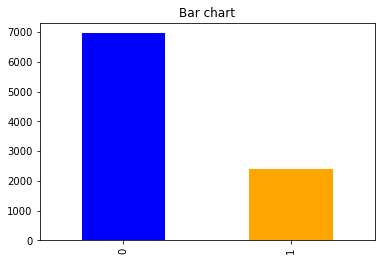

In [39]:
count_Class=pd.value_counts(df["spam"], sort= True)
count_Class.plot(kind= 'bar', color= ["blue", "orange"])
plt.title('Bar chart')
plt.show()

In [ ]:
# def dummy_fun(doc):
#     return doc

In [300]:
vectorizer = TfidfVectorizer(analyzer='word', tokenizer=dummy_fun, preprocessor=dummy_fun, token_pattern=None)

In [301]:
features_subject_train = vectorizer.fit_transform(X_train['clean_subject'])
features_subject_test = vectorizer.transform(X_test['clean_subject'])

In [302]:
vectorizer.get_feature_names()

['',
 '0',
 '00210030600',
 '00326',
 '00330',
 '01128',
 '01131',
 '0137cpnx4448g13',
 '0179mfrp5640z13',
 '02',
 '022002',
 '03',
 '030702',
 '05',
 '05152',
 '053634',
 '0545',
 '057',
 '05775748',
 '062901',
 '070601',
 '07102002',
 '07112002',
 '07122002',
 '07132001',
 '07132002',
 '07172002',
 '07182002',
 '071902e',
 '07192002',
 '07202002',
 '07222002',
 '0726',
 '0753hheu343412',
 '0800',
 '080301',
 '08262002',
 '08568',
 '091',
 '091302',
 '0922lkvt8113rfxd3342c21',
 '0973',
 '0989sqj7',
 '1',
 '10',
 '100',
 '1000',
 '10000',
 '100000',
 '100000s',
 '1006',
 '1008',
 '1012',
 '10132',
 '10148',
 '10206',
 '102132000',
 '1024',
 '102424',
 '1030',
 '103120',
 '1046',
 '10469',
 '1052',
 '1052002',
 '1053',
 '1054',
 '1075',
 '10782',
 '10891',
 '1090',
 '1093',
 '10k',
 '10mbs',
 '10th',
 '10x',
 '11',
 '110',
 '1100',
 '1104',
 '11058',
 '1111',
 '11150',
 '11180',
 '114',
 '1147',
 '1167',
 '1170',
 '11781',
 '11956',
 '12',
 '1200bps',
 '12021',
 '12083',
 '121',
 '12144

In [41]:
features_subject_train

<6547x5866 sparse matrix of type '<class 'numpy.float64'>'
	with 26624 stored elements in Compressed Sparse Row format>

In [42]:
features_body_train = vectorizer.fit_transform(X_train['clean_body'])
features_body_test = vectorizer.transform(X_test['clean_body'])

In [43]:
features_body_train

<6547x77396 sparse matrix of type '<class 'numpy.float64'>'
	with 694569 stored elements in Compressed Sparse Row format>

In [44]:
from scipy import sparse
features_joined_train = sparse.hstack((features_subject_train, features_body_train), format='csr') 
features_joined_test = sparse.hstack((features_subject_test, features_body_test), format='csr') 

In [45]:
features_joined_train

<6547x83262 sparse matrix of type '<class 'numpy.float64'>'
	with 721193 stored elements in Compressed Sparse Row format>

## Feature Selection
Only need 1% (or less) of the features to predict spam without overfitting.  This runs really fast.

In [116]:
selector = SelectPercentile(f_classif, percentile=1)

In [117]:
selector.fit(features_subject_train, y_train)
features_subject_train_sel = selector.transform(features_subject_train).toarray()
features_subject_test_sel = selector.transform(features_subject_test).toarray()

In [118]:
features_subject_train_sel.shape

(6547, 59)

In [119]:
selector.fit(features_body_train, y_train)
features_body_train_sel = selector.transform(features_body_train).toarray()
features_body_test_sel = selector.transform(features_body_test).toarray()

In [120]:
features_body_train_sel.shape

(6547, 773)

In [121]:
selector.fit(features_joined_train, y_train)
features_joined_train_sel = selector.transform(features_joined_train).toarray()
features_joined_test_sel = selector.transform(features_joined_test).toarray()

In [122]:
features_joined_train_sel.shape

(6547, 832)

## Modeling

In [123]:
# Baseline accuracy of 74% with class imbalance
df['spam'].value_counts(normalize=True)

0    0.743505
1    0.256495
Name: spam, dtype: float64

In [ ]:
# neg_class_prob_sorted = .feature_log_prob_[0, :].argsort()[::-1]
# pos_class_prob_sorted = NB_optimal.feature_log_prob_[1, :].argsort()[::-1]

# print(np.take(count_vect.get_feature_names(), neg_class_prob_sorted[:10]))
# print(np.take(count_vect.get_feature_names(), pos_class_prob_sorted[:10]))

In [306]:
def measure_time(func, name, percentile, features, vectorizer):
    start = time.process_time()
    score_train, score_test, model = func() #outputs train and test score
    processing_time = time.process_time() - start
   # print(vectorizer.get_feature_names())
    #print(feature_log_prob_[1, :].argsort()[::-1])
    #print((np.take(vectorizer.get_feature_names(),    model.coef_[0, :].argsort()[::-1][:10])))
    return [name, percentile, round(score_train,4), round(score_test, 4), features, round(processing_time, 4)], model.feature_log_prob_[0, :].argsort()[::-1], model.feature_log_prob_[1, :].argsort()[::-1]


In [185]:
# All subject features - overfits training set by 5.5%
features_subject_train_5_percent = features_subject_train.toarray()
features_subject_test_5_percent = features_subject_test.toarray()
def run_model1(): 
    model1a = MultinomialNB()
    model1a.fit(features_subject_train_5_percent, y_train)
    score_train = model1a.score(features_subject_train_5_percent, y_train)
    score_test = model1a.score(features_subject_test_5_percent, y_test)
    return score_train, score_test, model1a

In [186]:
# 1% of subject features - no overfitting
def run_model2():
    model1b = MultinomialNB()
    model1b.fit(features_subject_train_sel, y_train)
    score_train = model1b.score(features_subject_train_sel, y_train)
    score_test = model1b.score(features_subject_test_sel, y_test)
    return score_train, score_test, model1b

In [187]:
# 1% of body features
def run_model3():
    model2 = MultinomialNB()
    model2.fit(features_body_train_sel, y_train)
    score_train = model2.score(features_body_train_sel, y_train)
    score_test = model2.score(features_body_test_sel, y_test)
    return score_train, score_test, model2

In [188]:
# 0.1% of body features
selector = SelectPercentile(f_classif, percentile=0.1)
selector.fit(features_body_train, y_train)
features_body_train_sel_point1 = selector.transform(features_body_train).toarray()
features_body_test_sel_point1 = selector.transform(features_body_test).toarray()
def run_model4():
    model2b = MultinomialNB()
    model2b.fit(features_body_train_sel_point1, y_train)
    score_train = model2b.score(features_body_train_sel_point1, y_train)
    score_test = model2b.score(features_body_test_sel_point1, y_test)
    return score_train, score_test, model2b

In [189]:
# 1st percentile of subject + body features
# overfits training set by just 1%
def run_model5():
    model3 = MultinomialNB()
    model3.fit(features_joined_train_sel, y_train)
    score_train = model3.score(features_joined_train_sel, y_train)
    score_test = model3.score(features_joined_test_sel, y_test)
    return score_train, score_test, model3

In [190]:
# 0.1% of subject + body features, similar to body only, not worth the complexity
selector = SelectPercentile(f_classif, percentile=0.1)
selector.fit(features_joined_train, y_train)
features_joined_train_sel_point_1 = selector.transform(features_joined_train).toarray()
features_joined_test_sel_point_1 = selector.transform(features_joined_test).toarray()
def run_model6():
    model2b = MultinomialNB()
    model2b.fit(features_joined_train_sel_point_1, y_train)
    score_train = model2b.score(features_joined_train_sel_point_1, y_train)
    score_test = model2b.score(features_joined_test_sel_point_1, y_test)
    return score_train, score_test, model2b 

In [307]:
result1, neg_priority1, pos_priority1 = measure_time(run_model1, 'subject', 100, features_subject_train_5_percent.shape[1], vectorizer)
result2, neg_priority2, pos_priority2 = measure_time(run_model2, 'subject', 1, features_subject_train_sel.shape[1], vectorizer)
result3, neg_priority3, pos_priority3 = measure_time(run_model3, 'body', 1, features_body_train_sel.shape[1], vectorizer)
result4, neg_priority4, pos_priority4 = measure_time(run_model4, 'body', .1, features_body_train_sel_point1.shape[1], vectorizer)
result5, neg_priority5, pos_priority5 = measure_time(run_model5, 'subject+body', 1, features_joined_train_sel.shape[1], vectorizer)
result6, neg_priority6, pos_priority6 = measure_time(run_model6, 'subject+body', .1, features_joined_test_sel_point_1.shape[1], vectorizer)

result = [result1, result2, result3, result4, result5, result6 ]

In [308]:
print(tabulate(result, headers=['Type', 'Percentile of Features', 'Train Accuracy', 'Test Accuracy', '# of Features', 'Processing Time' ]))

Type            Percentile of Features    Train Accuracy    Test Accuracy    # of Features    Processing Time
------------  ------------------------  ----------------  ---------------  ---------------  -----------------
subject                          100              0.965            0.9091             5866             0.6178
subject                            1              0.8027           0.8004               59             0.0139
body                               1              0.9371           0.9341              773             0.0925
body                               0.1            0.8349           0.8325               78             0.029
subject+body                       1              0.9442           0.9437              832             0.1276
subject+body                       0.1            0.8392           0.8411               84             0.0218


In [309]:
def investigate_priority(vectorizer, priority): 
    #priority_words = (np.take(vectorizer.get_feature_names(),    priority[:5800]))
    print((np.take(vectorizer.get_feature_names(),    priority[:100])))
    #real_words = priority_words in english_words
    #print(type(priority_words))
    #print(list(priority_words))
    #print(priority_words)
    #real_words = filter(lambda x: x in english_words, list(priority_words))
    #return real_words

In [320]:
investigate_priority(vectorizer, neg_priority5)

['1030' '07132002' '24632' '100000s' 'attract' '' '100000' '10' 'award'
 '11150' 'attraction' '905' '6gho10' '29658' '102424' '1012'
 '4924161298765444333' 'asked' 'advanced' '800' 'asian' 'auctioned'
 'automotive' 'anchordesk' 'aanfh' '37661' 'auctions' '7222002' '7x'
 'annuity' '1000' '486' 'area' 'analog' '9652cyuh7164rdh15' '6bftc'
 '60whitelistcf131132' '97m' '911' 'attempt' '6465' '441' 'articles'
 'auto' 'agency' 'aymou' 'artist' 'ans' '27886' 'alone' '38191297' 'an'
 '67' 'animated' 'anolther' '200' '9959glxz3738hfdn8831kbee525' 'austin'
 '6801wbrq4940mjbj46319' '4863d5' 'analyses' 'apples' '4995' 'analysis'
 'alreadycompiled' 'auction' '73' '16540' 'ageing' 'ashfield' 'applied'
 'allows' 'annoyance' 'advertis' 'affiliate' '25735' '813' 'arbitrary'
 '20021202' '31' 'await' '7595' 'ascii' '9995' '828' 'annuity5'
 '5026hbtl0754g13' 'avant' '5182' 'almost' '55606otc1'
 '7325zmhy2201heqy577820' 'approval' 'advharvest' '8' '9200'
 'applications' '1699' '2467szaw6857erkg8484hnwz33327

In [319]:
investigate_priority(vectorizer, pos_priority5)

['1030' '' '200gb' '29658' '441' '07102002' 'alqaedas' 'absurdity'
 '7222002' 'am' '20020910' '242' '3d' '55606otc1' 'always' '1699'
 '4139yaek39' 'avoidance' 'asked' 'allmerica' '0179mfrp5640z13' '33'
 'annoyance' '7393' '300' '091' 'action' '97m' 'addand' 'auto' '030702'
 'amaze' '4658' '8k' 'ass' '1' 'authortracker' '9009zrld0486vnhz4718'
 '08568' '21815' '07132001' 'accept' 'apps' '5182' 'activist' 'agai'
 '20020731' '7595' '951' 'apples' 'antiobesity' 'attacking' 'alternatives'
 '2968zuyw7202ztvw049920' 'activebuddy' '9879' '03' '960' 'advertis' '50'
 '07132002' '1052002' 'aim' 'anonymity' 'abusersimages' '60'
 '2348033357110' 'angry' '062901' '2002' 'andor' '20020823' 'alles' 'ab'
 '22311' '12678' 'annuities' '24772' 'already' '912002' 'actors' '0973'
 '28' 'alqaida' 'b20hd' '20020926' '02' '922' 'amazing'
 '2467szaw6857erkg8484hnwz33327' '1535' '700mm' 'autorun' 'anvx' '3500'
 '07192002' '700' '5214' 'adaptive' '10148']


## Sampling Methodology <a id='sampling-methodology'/>

#### Per the code above we used a 70/30 train test sample split

## Model's Performance Analysis <a id='performance-analysis'/>

# Model Interpretability & Explainability <a id='model-explanation'>

Which variables were more important and why?

How did you come to the conclusion these variables were important how how should the audience interpret this?

## Examining Feature Importance <a id='examining-feature-importance'/>

# Conclusion <a id='conclusion'>

What are you proposing to the audience with your models and why?

How should your audience interpret your conclusion and whwere should they go moving forward on the topic?

What other approaches do you recommend exploring?

Bring it all home!

### Final Model Proposal <a id='final-model-proposal'/>

### Future Considerations and Model Enhancements <a id='model-enhancements'/>

### Alternative Modeling Approaches <a id='alternative-modeling-approaches'>